In [11]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose, walking_pose

import cv2


from flygym.util.decentralized_controller import (define_swing_stance_starts, update_stepping_advancement, compute_leg_scores,
                                               rule1_corresponding_legs, rule2_corresponding_legs, rule3_corresponding_legs,
                                               rule1_weight, rule2_weight, rule2_weight_contralateral, rule3_weight, rule3_weight_contralateral,
                                               percent_margin)

In [12]:
# Initialize simulation
run_time = 1
out_dir = Path("../decentralized_ctrl")

enable_adhesion = True

sim_params = MuJoCoParameters(
    timestep=2e-4,
    render_mode="saved",
    render_playspeed=0.1,
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    draw_contacts=False,
    adhesion_off_duration=0.05,
)

nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

In [13]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [14]:
print('Dict keys:', data.keys())
print('Length of time series:', data['joint_RFCoxa'])
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1', 'swing_stance_idx', 'swing_stance_time'])
Length of time series: [0.61922731 0.61871353 0.61819975 ... 0.63212368 0.6256755  0.61922731]
Metadata: {'timestep': 0.0001, 'source': 

In [15]:
# Interpolate 5x
num_steps_base = int(run_time / nmf.timestep)
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [16]:
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]

# get all swing stance starts and get the shortes swing possible
# Every leg needs to have the same stance start and swing start

swing_start = max(list(data["swing_stance_time"]["swing"]))/nmf.timestep
stance_start = min(list(data["swing_stance_time"]["swing"]))/nmf.timestep

leg_swing_starts = {}
leg_stance_starts = {}

for l in legs:
    leg_swing_starts[l] = swing_start
    leg_stance_starts[l] = stance_start

#leg_swing_starts, leg_stance_starts, position_data, touch_sensor_data = define_swing_stance_starts(nmf, data_block, use_adhesion=enable_adhesion, n_steps_stabil=2000)

In [17]:
# Initialize simulation
n_stabilisation_steps = 2000
# Run the simulation for a few steps to stabilise the system before starting the contoller
num_steps = num_steps_base + n_stabilisation_steps

#Define rule variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# For each leg the ids of the force sensors that are attached to it
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.contact_sensor_placements):
    for leg in legs:
        if leg in collision_geom:
            leg_force_sensors_ids[leg].append(i)   

In [18]:
np.random.seed(42)

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)

nmf.reset()

# Track the number of steps taken. It will be used to determine the stpping probability in the random stepper
number_of_taken_steps = 0
leg_scores = np.zeros(len(legs))

obs_list_cruse_flat = []
all_initiated_legs = []

adhesion = np.zeros(6)

#Run the actual simulation
for i in trange(num_steps):

    #Decide in which leg to step
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1) or stepping_advancement[initiating_leg] > 0:
        initiating_leg = None
    else:
        stepping_advancement[initiating_leg] += 1
        all_initiated_legs.append([initiating_leg, i])
        number_of_taken_steps += 1
        #print("Stepping leg: ", legs[initiating_leg], " at step: ", i)
    
    joint_pos = data_block[joint_ids, stepping_advancement[match_leg_to_joints]]

    if enable_adhesion:
        adhesion = nmf.get_adhesion_vector()
    else:
        adnesion = np.zeros(6)

    action = {'joints': joint_pos, "adhesion":adhesion}
    obs, info, _, _, _ = nmf.step(action)
    nmf.render()
    obs_list_cruse_flat.append(obs)

    stepping_advancement = update_stepping_advancement(stepping_advancement, legs, interp_step_duration)

    rule1_contrib, rule2_contrib, rule3_contrib  = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                                                      rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                                                      rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                                                      stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration, legs)
    
    all_legs_rule1_scores[:, i] = rule1_contrib
    all_legs_rule2_scores[:, i] = rule2_contrib
    all_legs_rule3_scores[:, i] = rule3_contrib

    leg_scores = rule1_contrib + rule2_contrib + rule3_contrib
        
    all_leg_scores[:, i] = leg_scores

nmf.save_video(out_dir / "cruse_flat.mp4")
nmf.close()

distances = obs_list_cruse_flat[n_stabilisation_steps]["fly"][0][:2] - obs_list_cruse_flat[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

100%|██████████| 7000/7000 [00:36<00:00, 190.49it/s]


Forward distance travelled:  0.023541758250630374
Lateral distance travelled:  -0.16387228224654385


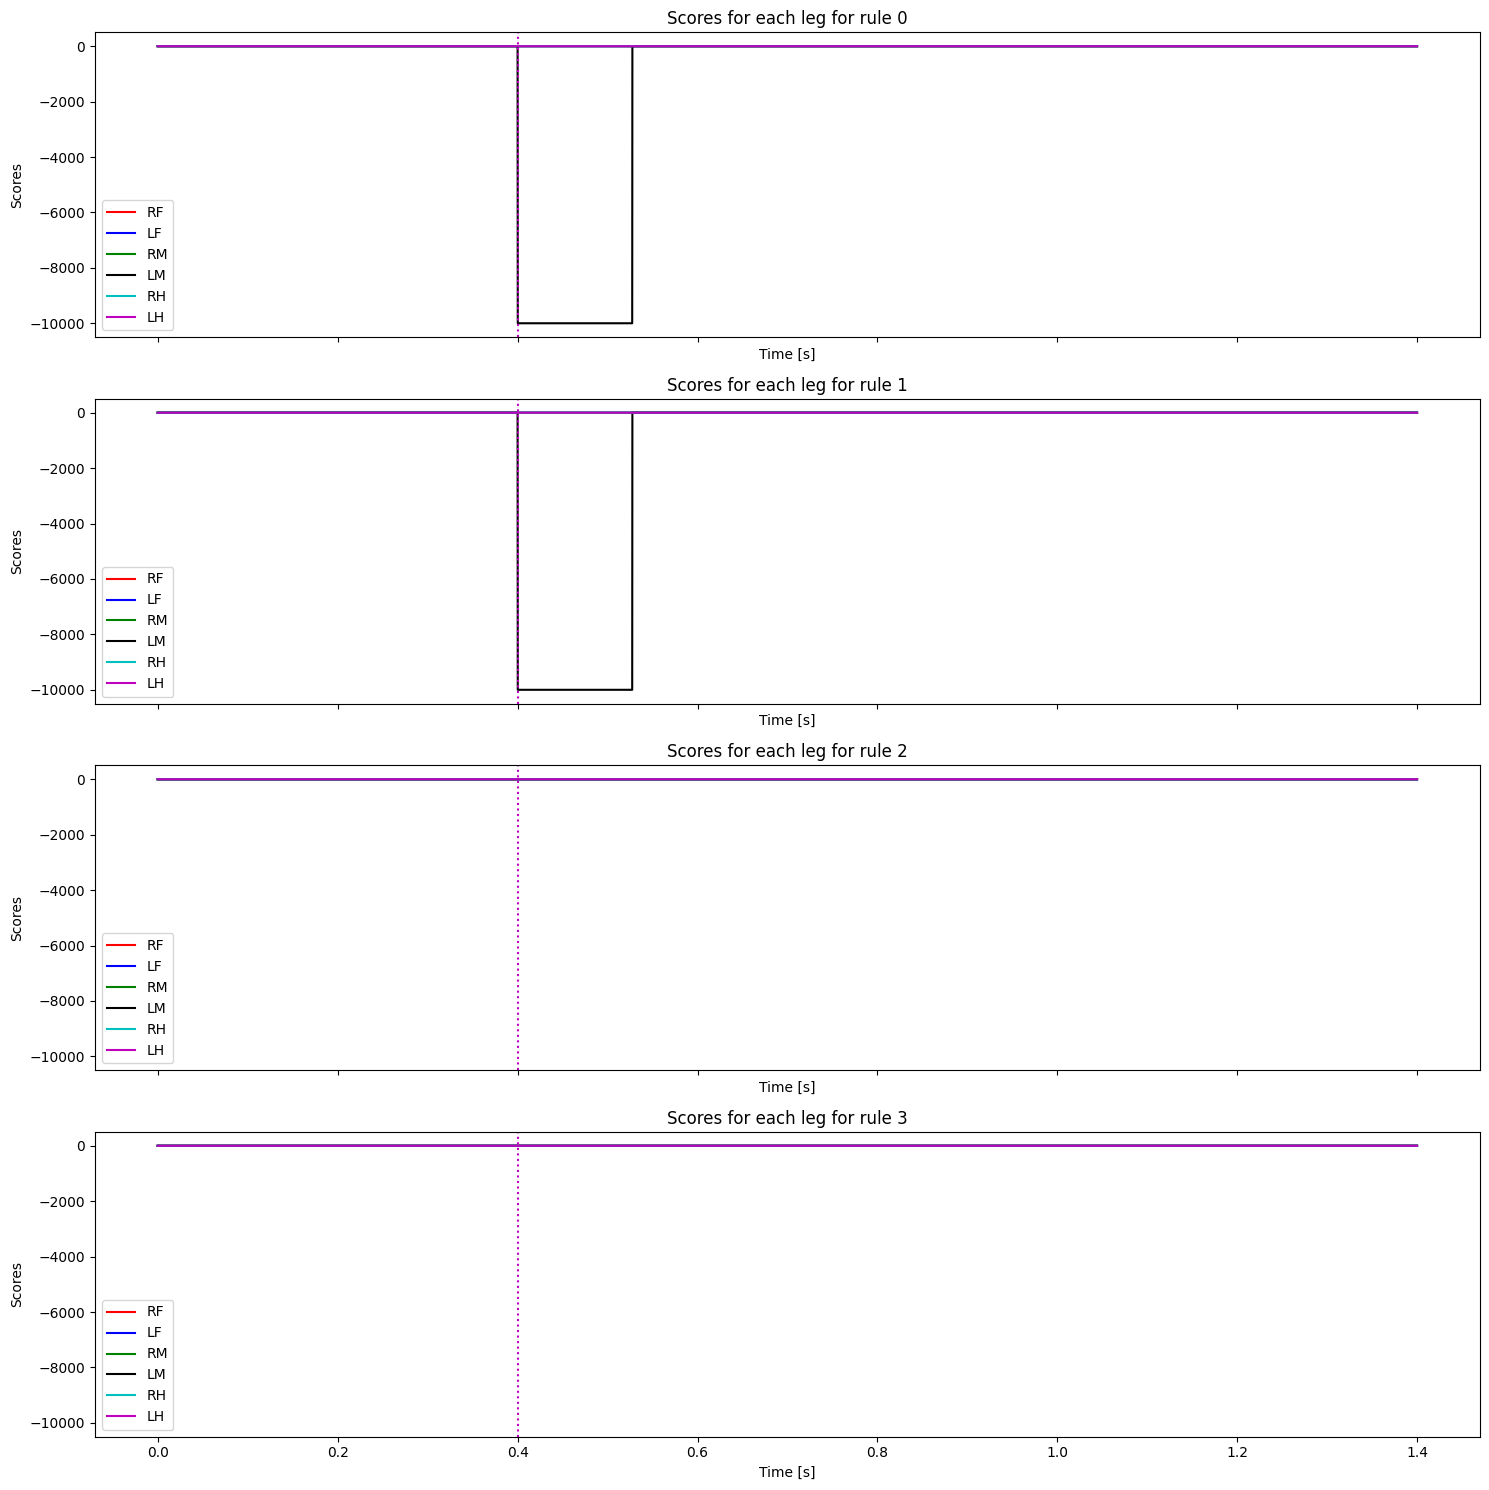

In [19]:
# Plot the evolution of the scores for each leg
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True, sharey=True)

t_ids = np.arange(0, num_steps, 1)
time = t_ids*nmf.timestep

leg_of_interest = ["RF", "LF", "RM", "LM", "RH", "LH"]
colors = ["r", "b", "g", "k", "c", "m"]
j_ids = np.tile([legs.index(leg) for leg in leg_of_interest], (len(t_ids), 1)).T

for a, (ax, rule_score) in enumerate(zip(axs, [all_leg_scores[j_ids, t_ids], all_legs_rule1_scores, all_legs_rule2_scores, all_legs_rule3_scores])):
    for i, l_score in enumerate(rule_score[j_ids, t_ids]):
        if i ==0:
            ax.set_title("Scores for each leg")
        else:
            ax.set_title("Scores for each leg for rule "+str(a))
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Scores")

        ax.plot(time, l_score, c=colors[i], linestyle="-", label=leg_of_interest[i])
    
    for leg_id, step in all_initiated_legs:
        color_index = leg_of_interest.index(legs[leg_id])
        #print(color_index, step)
        ax.axvline(time[step], color=colors[color_index], linestyle=":")
    ax.legend()

fig.tight_layout()
plt.show()

In [20]:
from ipywidgets import Video
Video.from_file(out_dir / 'cruse_flat.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')